**India AI CyberGuard AI Hackathon**<br>
• Project Title: Cybercrime Report Classification<br>
• Problem Statement: Development of an NLP Model for Text Analytics and Classification<br>
• Objective: To develop an NLP model that categorizes complaint based on victim, type of fraud and other relevant parameters used for text classification and preparing the final model. 



**_Step 1: Importing Libraries and Loading the Dataset_**<br>
This step involves importing the necessary Python libraries that provide functionality for data manipulation, visualization, natural language processing (NLP), machine learning, and neural network modeling. The dataset containing cybercrime reports is then loaded for processing and analysis.<br>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AdamW
from tqdm import tqdm
import numpy as np
import pandas as pdb
import pandas as pd
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertModel

In [2]:
# Load the training dataset
train_df = pd.read_csv('train.csv')  # Load training data from a CSV file
train_df.head()  # Display the first few rows of the training dataset for verification

,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...


In [3]:
# Load the testing dataset
test_df = pd.read_csv('test.csv')  # Load testing data from a CSV file
test_df.head()  # Display the first few rows of the testing dataset for verification

,category,sub_category,crimeaditionalinfo
0,RapeGang Rape RGRSexually Abusive Content,NaN,Sir namaskar mein Ranjit Kumar PatraPaise neh...
1,Online Financial Fraud,DebitCredit Card FraudSim Swap Fraud,KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT
2,Cyber Attack/ Dependent Crimes,SQL Injection,The issue actually started when I got this ema...
3,Online Financial Fraud,Fraud CallVishing,I am amit kumar from karwi chitrakoot I am tot...
4,Any Other Cyber Crime,Other,I have ordered saree and blouse from rinki s...


**_Step 2: Data Cleaning and Preprocessing_**<br>
Data cleaning refers to the process of identifying and correcting (or removing) errors and inconsistencies in the dataset to ensure data quality. Preprocessing involves preparing raw text data for feature extraction by applying transformations like tokenization, lemmatization, and removal of irrelevant elements.

    Preprocess the input text by performing the following steps:
    1. Convert text to lowercase.
    2. Remove special characters, numbers, and punctuations.
    3. Tokenize the text into individual words.
    4. Remove stopwords and apply lemmatization to each token.
    5. Reconstruct the cleaned text.

In [4]:
# Filter classes in the training data based on minimum samples
min_samples = 2  # Define the minimum number of samples required per class
valid_classes = train_df['sub_category'].value_counts()[train_df['sub_category'].value_counts() >= min_samples].index
# Retain only rows with sub-categories that meet the minimum sample requirement
train_df = train_df[train_df['sub_category'].isin(valid_classes)]

# Display the number of unique sub-categories after filtering
print(train_df['sub_category'].nunique())

34


In [5]:
# Clean the training dataset
print(f"Initial dataset shape: {train_df.shape}")  # Show the initial shape of the training dataset

# Remove rows with missing values
train_df = train_df.dropna()  # Drop rows with any missing values
print(f"After removing rows with missing values: {train_df.shape}")  # Display updated shape after removing null rows

# Remove duplicate rows
train_df = train_df.drop_duplicates()  # Eliminate duplicate rows from the dataset
print(f"After removing duplicate rows: {train_df.shape}")  # Display updated shape after removing duplicates

# Display final dataset information
print("\nFinal dataset info:")
print(train_df.info())  # Print a detailed summary of the training dataset

Initial dataset shape: (87094, 3)
After removing rows with missing values: (87073, 3)
After removing duplicate rows: (82017, 3)

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 82017 entries, 0 to 93685
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            82017 non-null  object
 1   sub_category        82017 non-null  object
 2   crimeaditionalinfo  82017 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB
None


In [6]:
# Import libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')  # Download the list of English stopwords
nltk.download('wordnet')    # Download WordNet for lemmatization
nltk.download('punkt')      # Download the tokenizer

# Initialize stopwords set and lemmatizer
stop_words = set(stopwords.words('english'))  # Load English stopwords into a set for quick lookups
lemmatizer = WordNetLemmatizer()  # Initialize the WordNet lemmatizer

# Handle missing values in critical columns
train_df.dropna(subset=['sub_category', 'crimeaditionalinfo'], inplace=True)  # Ensure required columns have no missing values in training data
test_df.dropna(subset=['sub_category', 'crimeaditionalinfo'], inplace=True)   # Ensure required columns have no missing values in testing data

# Define a text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)  # Join tokens back into a single string

# Create a mapping of categories to their unique sub-categories
category_dict = train_df.groupby('category')['sub_category'].apply(lambda x: list(x.unique())).to_dict()

# Apply the preprocessing function to the 'crimeaditionalinfo' column
train_df['cleaned_description'] = train_df['crimeaditionalinfo'].apply(preprocess_text)  # Clean and preprocess training descriptions
test_df['cleaned_description'] = test_df['crimeaditionalinfo'].apply(preprocess_text)   # Clean and preprocess testing descriptions

# Display a sample of the cleaned data for verification
print(train_df[['sub_category', 'crimeaditionalinfo', 'cleaned_description']].head())  # Show the processed training data
print(test_df[['sub_category', 'crimeaditionalinfo', 'cleaned_description']].head())  # Show the processed testing data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                        sub_category  \
0  Cyber Bullying  Stalking  Sexting   
1                  Fraud CallVishing   
2           Online Gambling  Betting   
3                   Online Job Fraud   
4                  Fraud CallVishing   

                                  crimeaditionalinfo  \
0  I had continue received random calls and abusi...   
1  The above fraudster is continuously messaging ...   
2  He is acting like a police and demanding for m...   
3  In apna Job I have applied for job interview f...   
4  I received a call from lady stating that she w...   

                                 cleaned_description  
0  continue received random call abusive message ...  
1  fraudster continuously messaging asking pay mo...  
2  acting like police demanding money adding sect...  
3  apna job applied job interview telecalling res...  
4  received call lady stating send new phone vivo...  
                           sub_category  \
1  DebitCredit Card FraudSim Swap Fraud   
2     

**_Step 3: Exploratory Data Analysis (EDA)_**<br>
EDA is the process of analyzing and visualizing data to summarize its main characteristics. It helps identify patterns, detect anomalies, and gain insights into the data distribution.

• Category Distribution: A bar chart is used to display the number of samples per category, highlighting imbalances in the dataset.<br>
• Top Subcategories: A similar analysis focuses on the most frequent subcategories to guide model evaluation.<br>
• Word Cloud: A visual representation of the most frequent words in the dataset, offering insights into commonly occurring terms.<br>


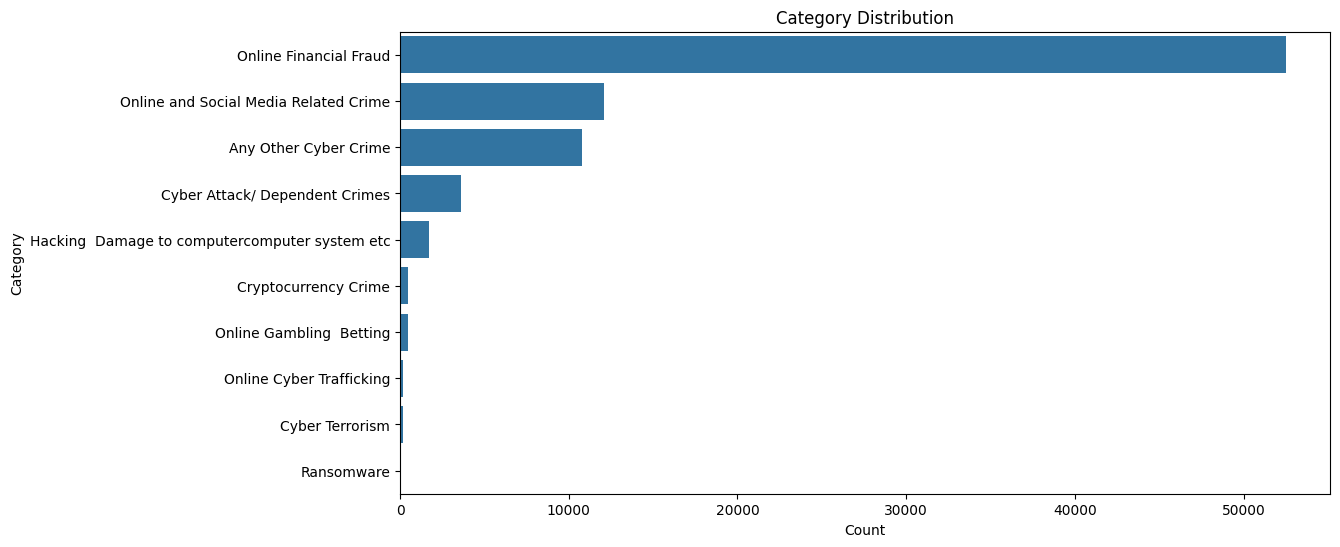

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of categories in the training dataset
plt.figure(figsize=(12, 6))  # Set figure size for better clarity
sns.countplot(
    y='category', 
    data=train_df, 
    order=train_df['category'].value_counts().index  # Order by count
)
plt.title("Category Distribution")  # Add title to the plot
plt.xlabel("Count")  # Label for x-axis
plt.ylabel("Category")  # Label for y-axis
plt.show()  # Display the plot


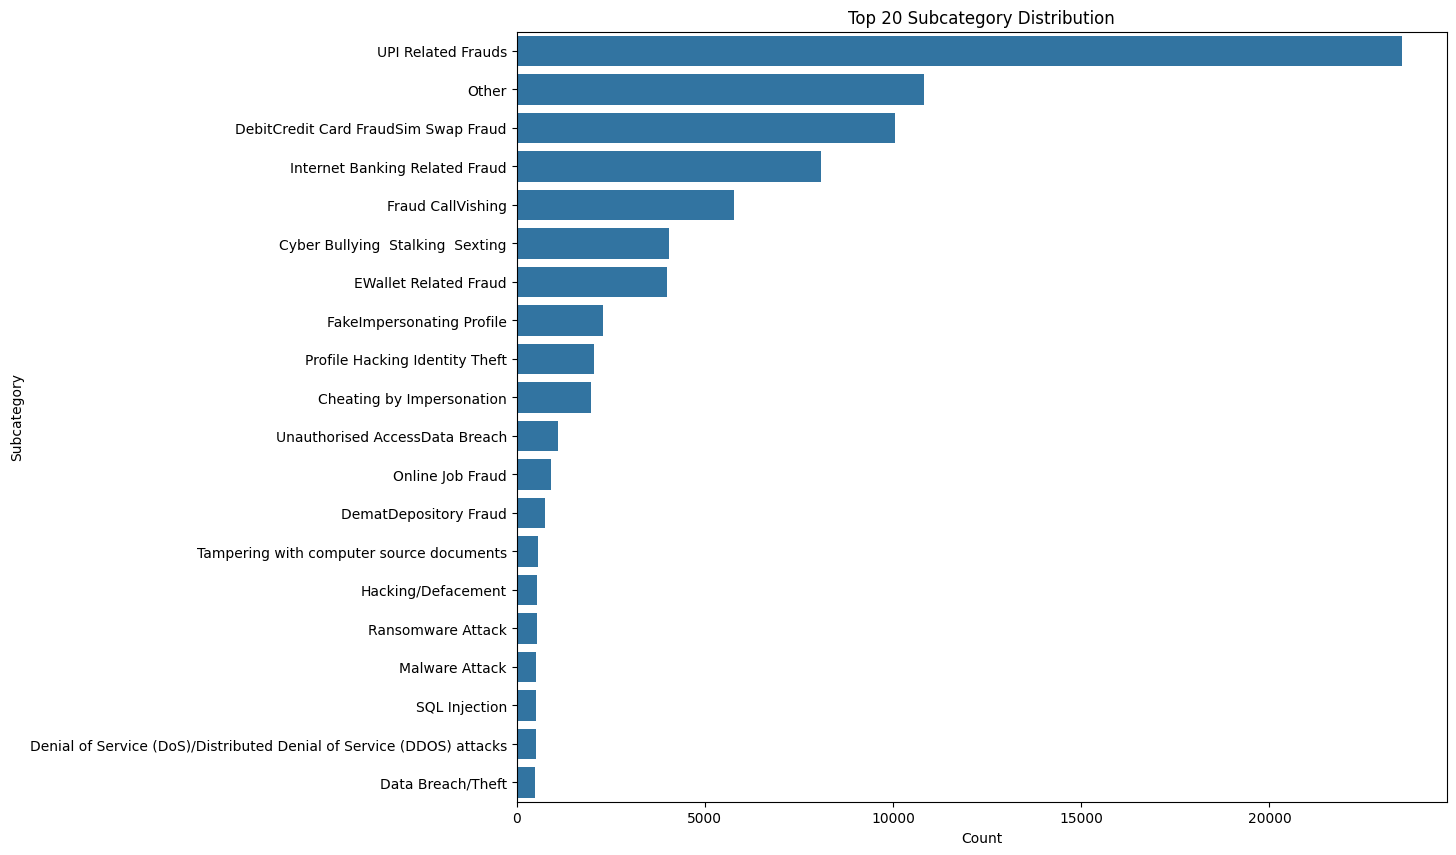

In [ ]:
# Visualize the distribution of the top 20 subcategories
plt.figure(figsize=(12, 10))  # Set figure size for better visualization
top_subcategories = train_df['sub_category'].value_counts().head(20)  # Get the top 20 subcategories
sns.barplot(
    x=top_subcategories.values, 
    y=top_subcategories.index  # Set y-axis to subcategory names
)
plt.title("Top 20 Subcategory Distribution")  # Add plot title
plt.xlabel("Count")  # Label for x-axis
plt.ylabel("Subcategory")  # Label for y-axis
plt.show()  # Render the plot


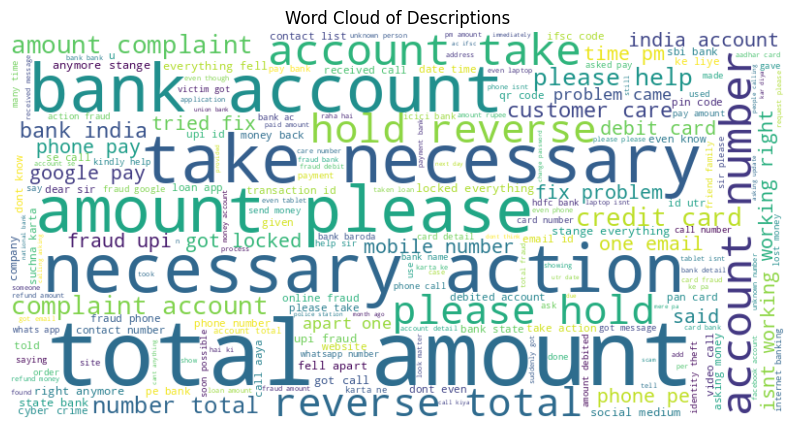

In [ ]:
# Import WordCloud for visualization of descriptive insights
from wordcloud import WordCloud

# Combine all cleaned descriptions into a single text
text = " ".join(train_df['cleaned_description'].values)

# Generate a word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'  # Use a white background for better contrast
).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud
plt.axis('off')  # Remove axis for better visual appeal
plt.title("Word Cloud of Descriptions")  # Add title to the plot
plt.show()  # Render the plot


In [7]:
# Calculate and display imbalance percentages for categories
category_counts = train_df['category'].value_counts(normalize=True) * 100
print("\nCategory Imbalance (%):")  # Display imbalance for categories
print(category_counts)

# Calculate and display imbalance percentages for subcategories
sub_category_counts = train_df['sub_category'].value_counts(normalize=True) * 100
print("\nSubcategory Imbalance (%):")  # Display imbalance for subcategories
print(sub_category_counts.head(10))  # Show the top 10 subcategories for clarity



Category Imbalance (%):
category
Online Financial Fraud                            64.006243
Online and Social Media Related Crime             14.723777
Any Other Cyber Crime                             13.181414
Cyber Attack/ Dependent Crimes                     4.399088
Hacking  Damage to computercomputer system etc     2.083714
Cryptocurrency Crime                               0.576710
Online Gambling  Betting                           0.541351
Online Cyber Trafficking                           0.223124
Cyber Terrorism                                    0.196301
Ransomware                                         0.068279
Name: proportion, dtype: float64

Subcategory Imbalance (%):
sub_category
UPI Related Frauds                      28.684297
Other                                   13.181414
DebitCredit Card FraudSim Swap Fraud    12.246242
Internet Banking Related Fraud           9.871124
Fraud CallVishing                        7.047319
Cyber Bullying  Stalking  Sexting        4

**_Step 4: Text Feature Extraction using BERT_**<br>
Feature extraction involves transforming raw text data into a numerical representation that can be processed by machine learning models. BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art NLP model that generates high-quality embeddings by capturing semantic and contextual information from text.<br>

    Extract BERT embeddings for a list of texts using batch processing.
    - texts: List of input strings.
    - batch_size: Number of texts to process in a single batch.
    Returns:
    - Tensor containing [CLS] token embeddings for each input.


In [ ]:
# Import pre-trained BERT model and tokenizer
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm  # Progress bar for batch processing

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Load the tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')  # Load the BERT model
bert_model.eval()  # Set model to evaluation mode (no training)

# Check device availability and move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
bert_model.to(device)  # Move model to the appropriate device

# Define a function to extract BERT embeddings in batches
def get_bert_embeddings(texts, batch_size=256):
    embeddings = []  # List to store embeddings
    with torch.no_grad():  # Disable gradient computation
        for i in tqdm(range(0, len(texts), batch_size)):  # Iterate over batches
            batch = texts[i:i + batch_size]  # Get the current batch
            inputs = tokenizer(
                batch,
                return_tensors="pt",  # Return PyTorch tensors
                truncation=True,  # Truncate inputs exceeding the max length
                padding=True,  # Pad inputs to the same length
                max_length=512  # Maximum token length
            ).to(device)  # Move inputs to the device
            outputs = bert_model(**inputs)  # Pass inputs through BERT
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract [CLS] token embeddings
            embeddings.append(cls_embedding)  # Append embeddings to the list
    embeddings = np.vstack(embeddings)  # Combine embeddings from all batches
    return torch.tensor(embeddings, dtype=torch.float)  # Convert to PyTorch tensor

# Apply the embedding function to the cleaned descriptions in the training dataset
bert_embeddings = get_bert_embeddings(train_df['cleaned_description'].tolist())  # Generate embeddings
print("Shape of BERT Embeddings:", bert_embeddings.shape)  # Print the shape of the resulting tensor


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [06:02<00:00,  1.13s/it]

Shape of BERT Embeddings: torch.Size([82017, 768])


In [ ]:
# Save the computed BERT embeddings to a file for reuse
torch.save(bert_embeddings, "bert_embeddings.pt")  # Save embeddings in PyTorch tensor format


In [8]:
# Encode unique sub-categories into numerical IDs in the training dataset
sub_categories = train_df['sub_category'].unique()  # Get unique sub-categories
sub_category_to_id = {sub_category: idx for idx, sub_category in enumerate(sub_categories)}  # Map sub-categories to unique IDs
train_df['sub_category_id'] = train_df['sub_category'].map(sub_category_to_id)  # Apply mapping to create a new column


In [9]:
# Encode unique sub-categories into numerical IDs in the testing dataset
sub_categories = test_df['sub_category'].unique()  # Get unique sub-categories
sub_category_to_id = {sub_category: idx for idx, sub_category in enumerate(sub_categories)}  # Map sub-categories to unique IDs
test_df['sub_category_id'] = test_df['sub_category'].map(sub_category_to_id)  # Apply mapping to create a new column


In [10]:
# Display unique encoded sub-category IDs in both train and test datasets
print("Unique Encoded Sub-Categories (Train):", train_df['sub_category_id'].unique())
print("Unique Encoded Sub-Categories (Test):", test_df['sub_category_id'].unique())


Unique Encoded Sub-Categories (Train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Unique Encoded Sub-Categories (Test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [11]:
# Load precomputed BERT embeddings from file
bert_embeddings = torch.load("bert_embeddings.pt")  # Load saved embeddings


C:\Users\sumit\AppData\Local\Temp\ipykernel_4176\1046865557.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_embeddings = torch.load("bert_embeddings.pt")  # Load sa

In [12]:
# Convert embeddings to NumPy array for further processing
embeddings = bert_embeddings.numpy()  # Convert PyTorch tensor to NumPy array

# Extract corresponding labels for the embeddings
labels = train_df['sub_category_id'].values  # Get encoded sub-category IDs as labels


**_Step 5: Data Splitting_**<br>
• Training Set (60%)<br>
• Testing Set (20%)<br>
• Validation (20%)<br>


In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary datasets
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels  # Stratify to ensure label distribution consistency
)

# Further split the temporary dataset into validation and test datasets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp  # Split evenly into validation and test sets
)

# Verify the number of samples in each dataset
print(f"Training data: {X_train.shape[0]}, Validation data: {X_val.shape[0]}, Test data: {X_test.shape[0]}")


Training data: 65613, Validation data: 8202, Test data: 8202


In [14]:
# Ensure all sub-categories across the dataset are included in the mapping
all_subcategories = train_df['sub_category'].unique()  # Get all unique sub-categories
sub_category_to_id = {sub_category: idx for idx, sub_category in enumerate(all_subcategories)}  # Create a consistent mapping

# Map sub-categories to IDs in the training dataset
train_df['sub_category_id'] = train_df['sub_category'].map(sub_category_to_id)


In [15]:
from torch.utils.data import Dataset
# Define a custom PyTorch Dataset to handle embeddings and labels
class CrimeDataset(Dataset):
    def __init__(self, embeddings, labels):

# Initialize the dataset with embeddings and labels.
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)  # Convert embeddings to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor
    def __len__(self):
# Return the total number of samples.
        return len(self.labels)
    def __getitem__(self, idx):
# Fetch the embedding and label for a given index.
        return self.embeddings[idx], self.labels[idx]


**_Step 6: Handling Class Imbalance_**<br>
Class imbalance occurs when some classes in the dataset have significantly fewer samples than others. This imbalance can bias the model toward predicting majority classes. SMOTE (Synthetic Minority Oversampling Technique) addresses this by creating synthetic samples for underrepresented classes.<br>

    Balance the dataset using SMOTE to handle class imbalance.
    Args:
    - X: Feature matrix (embeddings).
    - y: Target labels.
    Returns:
    - X_balanced: Resampled feature matrix.
    - y_balanced: Resampled labels.

In [16]:
from imblearn.over_sampling import SMOTE

# Define a function to balance the dataset using SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)  # Initialize SMOTE with a fixed random state
    X_balanced, y_balanced = smote.fit_resample(X, y)  # Perform oversampling
    return X_balanced, y_balanced


In [17]:
# Balance the training data using SMOTE to handle class imbalance
X_train_balanced, y_train_balanced = balance_data(X_train, y_train)

# Convert the balanced and split data into PyTorch Dataset objects
train_dataset = CrimeDataset(X_train_balanced, y_train_balanced)  # Balanced training dataset
val_dataset = CrimeDataset(X_val, y_val)  # Validation dataset
test_dataset = CrimeDataset(X_test, y_test)  # Test dataset

# Create DataLoaders for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No shuffle for testing


In [18]:
# Display the distribution of classes in the training data after SMOTE balancing
print("Class Distribution after SMOTE:", np.bincount(y_train_balanced))


Class Distribution after SMOTE: [18821 18821 18821 18821 18821 18821 18821 18821 18821 18821 18821 18821
 18821 18821 18821 18821 18821 18821 18821 18821 18821 18821 18821 18821
 18821 18821 18821 18821 18821 18821 18821 18821 18821 18821]


**_Step 7: Model Definition and Training_**<br>
The neural network is the core of the classification task. It consists of multiple layers that process embeddings and predict the appropriate class. Training involves optimizing the model's parameters to minimize the prediction error on the training data.<br>

Model Architecture: A feedforward neural network is defined with:

        Initialize the classifier with three fully connected layers and dropout for regularization.
        Args:
        - input_dim: Number of input features (embedding dimensions).
        - num_classes: Number of output classes (unique sub-categories).
        Define the forward pass for the model.
        Args:
        - x: Input tensor.
        Returns:
        - Output tensor after passing through the layers.
    

In [19]:
# Define the Crime Classifier neural network model
class CrimeClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CrimeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)  # First fully connected layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(512, 256)  # Second fully connected layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout for regularization
        self.fc3 = nn.Linear(256, num_classes)  # Final output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = self.dropout1(x)  # Apply dropout
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.dropout2(x)  # Apply dropout
        x = self.fc3(x)  # Linear output layer
        return x


In [20]:
from sklearn.preprocessing import StandardScaler

# Scale the embeddings for balanced training and consistent feature scaling
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)  # Fit and transform training data
X_val = scaler.transform(X_val)  # Transform validation data
X_test = scaler.transform(X_test)  # Transform test data


In [21]:
# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model with input dimensions and number of classes
input_dim = X_train_balanced.shape[1]  # Embedding dimensions
num_classes = len(np.unique(y_train_balanced))  # Number of unique sub-categories
model = CrimeClassifier(input_dim, num_classes).to(device)  # Move model to the selected device

# Define class weights to handle imbalance during training
class_weights = torch.tensor(1.0 / np.bincount(y_train_balanced), dtype=torch.float32).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Cross-entropy loss with class weighting

# Set up the optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW optimizer with weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Step learning rate scheduler


In [22]:
# Normalize class weights to ensure they sum to 1
class_weights = torch.tensor(1.0 / np.bincount(y_train_balanced), dtype=torch.float32).to(device)
class_weights /= class_weights.sum()  # Normalize weights
print("Recalculated Class Weights:", class_weights.cpu().numpy())


Recalculated Class Weights: [0.02941177 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177
 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177
 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177
 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177
 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177 0.02941177
 0.02941177 0.02941177 0.02941177 0.02941177]


In [23]:
# Initialize lists to store training and validation metrics
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Training loop
for epoch in range(1, 6):  # Train for 20 epochs
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()  # Update model weights
        train_loss += loss.item()  # Accumulate loss
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()  # Count correct predictions

    # Calculate training accuracy
    train_accuracy = correct_train / len(train_dataset)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            correct_val += (outputs.argmax(dim=1) == labels).sum().item()

    val_accuracy = correct_val / len(val_dataset)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Step the learning rate scheduler
    scheduler.step()

    # Print metrics for the epoch
    print(f"Epoch {epoch}/20, Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Train Loss: 19844.68, Train Accuracy: 0.3676, Val Loss: 273.38, Val Accuracy: 0.3315
Epoch 2/20, Train Loss: 13962.98, Train Accuracy: 0.5329, Val Loss: 260.88, Val Accuracy: 0.3587
Epoch 3/20, Train Loss: 11770.21, Train Accuracy: 0.5960, Val Loss: 245.50, Val Accuracy: 0.3967
Epoch 4/20, Train Loss: 10619.23, Train Accuracy: 0.6293, Val Loss: 254.27, Val Accuracy: 0.3838
Epoch 5/20, Train Loss: 9860.76, Train Accuracy: 0.6512, Val Loss: 250.99, Val Accuracy: 0.4186


In [ ]:
# Initialize lists to store training and validation metrics
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Training loop
for epoch in range(1, 21):  # Train for 20 epochs
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()  # Update model weights
        train_loss += loss.item()  # Accumulate loss
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()  # Count correct predictions

    # Calculate training accuracy
    train_accuracy = correct_train / len(train_dataset)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            correct_val += (outputs.argmax(dim=1) == labels).sum().item()

    val_accuracy = correct_val / len(val_dataset)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Step the learning rate scheduler
    scheduler.step()

    # Print metrics for the epoch
    print(f"Epoch {epoch}/20, Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Train Loss: 5034.7545, Train Accuracy: 0.8296
Epoch 2/20, Train Loss: 5040.2542, Train Accuracy: 0.8288
Epoch 3/20, Train Loss: 5031.6165, Train Accuracy: 0.8296
Epoch 4/20, Train Loss: 5030.5226, Train Accuracy: 0.8297
Epoch 5/20, Train Loss: 5031.2915, Train Accuracy: 0.8294
Epoch 6/20, Train Loss: 5011.5043, Train Accuracy: 0.8299
Epoch 7/20, Train Loss: 5017.2055, Train Accuracy: 0.8299
Epoch 8/20, Train Loss: 5009.5249, Train Accuracy: 0.8297
Epoch 9/20, Train Loss: 5005.0886, Train Accuracy: 0.8304
Epoch 10/20, Train Loss: 5003.5919, Train Accuracy: 0.8304
Epoch 11/20, Train Loss: 5002.7528, Train Accuracy: 0.8305
Epoch 12/20, Train Loss: 5002.2847, Train Accuracy: 0.8303
Epoch 13/20, Train Loss: 4989.1974, Train Accuracy: 0.8311
Epoch 14/20, Train Loss: 4985.3845, Train Accuracy: 0.8310
Epoch 15/20, Train Loss: 4994.9908, Train Accuracy: 0.8312
Epoch 16/20, Train Loss: 4976.7940, Train Accuracy: 0.8310
Epoch 17/20, Train Loss: 4975.6415, Train Accuracy: 0.8314
Epoch 

In [ ]:
# Save the trained model's state dictionary for future inference
torch.save(model.state_dict(), "crime_pred_model.pth")


**_Step 8: Model Evaluation and Visualization_**<br>
Evaluation measures the model's performance using metrics like precision, recall, and F1-score. Visualization techniques, such as accuracy/loss plots and ROC curves, provide an intuitive understanding of the model's behavior.<br>

Metrics:
• Precision: The proportion of true positive predictions among all positive predictions.<br>
• Recall: The proportion of true positives identified out of all actual positives.<br>
• F1 Score: The harmonic mean of precision and recall, balancing their trade-offs.<br>
• ROC Curve: Plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for different thresholds, highlighting the model's discriminative ability.<br>
• Accuracy/Loss Trends: Graphical representations of the training process help identify issues like overfitting or underfitting.<br>

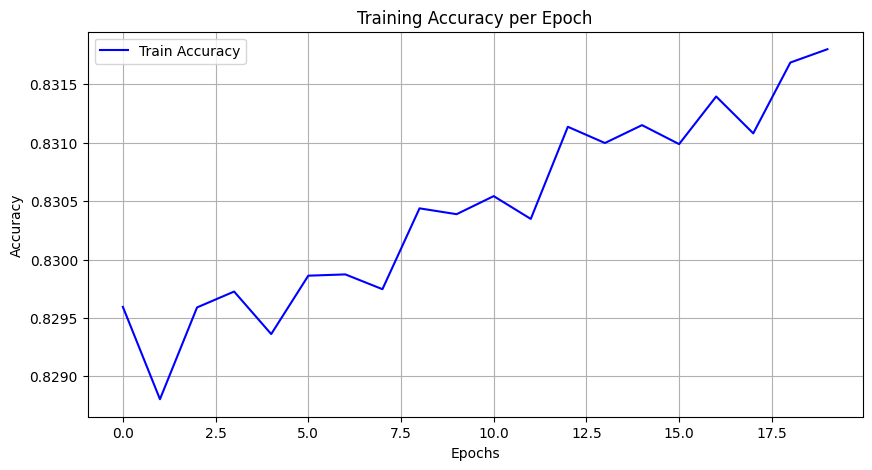

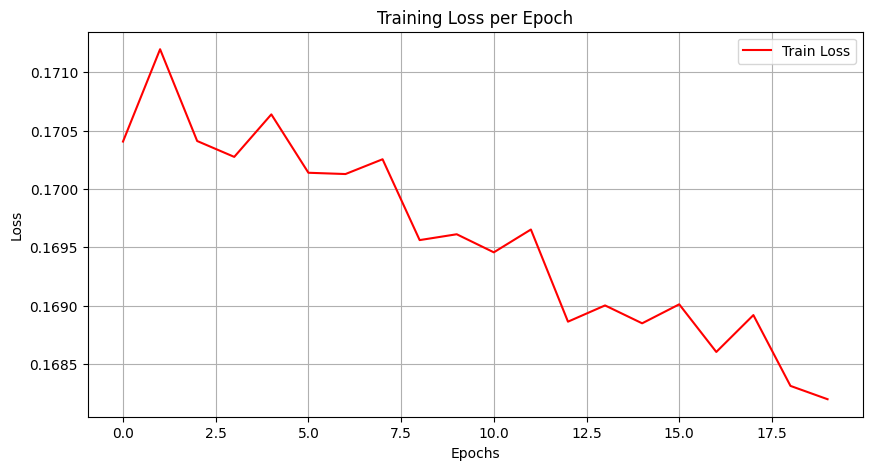

In [ ]:
def plot_training_metrics(train_losses, train_accuracies):
    
    # Calculate errors (1 - accuracy) as a proxy for loss
    errors = [1 - acc for acc in train_accuracies]

    # Plot Training Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(errors, label='Train Loss', color='red')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function with training metrics
plot_training_metrics(train_losses, train_accuracies)


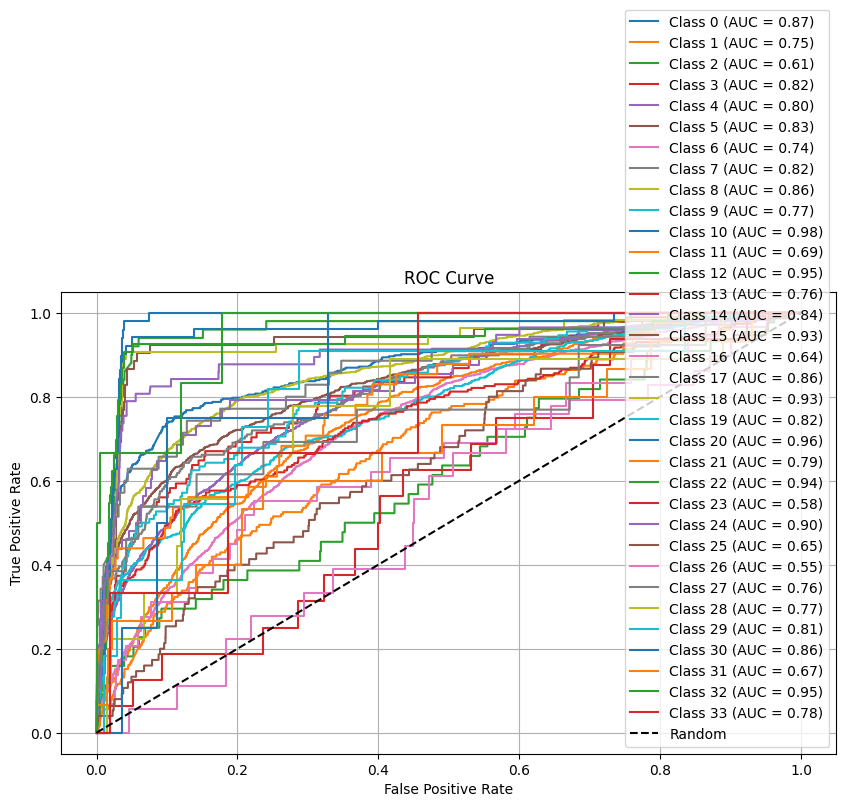

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(model, test_loader, num_classes):
    all_labels = []
    all_probs = []
    
    # Set model to evaluation mode and collect predictions
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities)
    
    # Binarize the labels for multi-class ROC computation
    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    all_probs = np.array(all_probs)
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Call the function to plot ROC-AUC
plot_roc_auc(model, test_loader, num_classes)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict labels for the test set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(predictions)
        all_labels.extend(labels.numpy())

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the metrics
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Precision: 0.4206
Recall: 0.4251
F1-Score: 0.4214


/lab/labenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# Mapping dictionary to map 15 categories to 3 main categories
main_category_mapping = {
    "Women/Child Related Crime": [
        "RapeGang Rape RGRSexually Abusive Content",
        "Sexually Explicit Act",
        "Sexually Obscene material",
        "Child Pornography CPChild Sexual Abuse Material CSAM",
        "Online Cyber Trafficking"
    ],
    "Financial Fraud Crimes": [
        "Online Financial Fraud",
        "Online Gambling Betting",
        "Cryptocurrency Crime"
        "UPI Related Frauds"
    ],
    "Other Cyber Crime": [
        "Any Other Cyber Crime",
        "Cyber Attack/ Dependent Crimes",
        "Online and Social Media Related Crime",
        "Hacking  Damage to computercomputer system etc",
        "Cyber Terrorism",
        "Ransomware",
        "Report Unlawful Content"
    ]
}

In [53]:
main_category_mapping.keys()

dict_keys(['Women/Child Related Crime', 'Financial Fraud Crimes', 'Other Cyber Crime'])

In [54]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Set the model to evaluation mode
bert_model.eval()

print("Pre-trained BERT model and tokenizer loaded successfully.")


Pre-trained BERT model and tokenizer loaded successfully.


In [55]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Mean pooling of token embeddings


In [56]:
category_dict = train_df.groupby('category')['sub_category'].apply(lambda x: list(x.unique())).to_dict()
    
def get_category(category_dict,predicted_subcategory):
    for category, subcategories in category_dict.items():
        if predicted_subcategory in subcategories:
            return category
            
def get_main_category(value):
    value = value.strip().lower()    
    for key, values in main_category_mapping.items():
        if any(val.strip().lower() == value for val in values):
            return key
    return None  

In [57]:
def predict_category_and_subcategory(text, model, device):
    # Get embedding for the input text
    embedding = get_text_embedding(text).to(device)
    
    # Pass the embedding through the trained model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(embedding)
    
    # Get the predicted subcategory index
    _, predicted_class = torch.max(output, dim=1)
    
    # Map the predicted class index to subcategory
    id_to_sub_category = {v: k for k, v in sub_category_to_id.items()}
    predicted_subcategory = id_to_sub_category[predicted_class.item()]
        
    # get cat
    cat=get_category(category_dict,predicted_subcategory)
    
    # get main category
    main_category=get_main_category(cat) 
    
    return main_category,cat, predicted_subcategory

**_Step 8: Model Validation_**<br>
An input text is passed to model to check the output categories and subcategories.<br>
It also proves the working efficiency. 

In [31]:
# Example prediction
text_input = "plz do something as I recieved a fake call and my  complte bank account money got lost"
main_category,category, predicted_subcategory = predict_category_and_subcategory(text_input, model, device)
# Print the result
print(f"Predicted Main Category: {main_category}")
print(f"Predicted category: {category}")
print(f"Predicted Subcategory: {predicted_subcategory}")

Predicted Main Category: Financial Fraud Crimes
Predicted category: Online Financial Fraud
Predicted Subcategory: UPI Related Frauds


In [ ]:
text_input = "I recieved a suspicious link on whatsapp and my all chat lost"
main_category,category, predicted_subcategory = predict_category_and_subcategory(text_input, model, device)
# Print the result
print(f"Predicted Main Category: {main_category}")
print(f"Predicted category: {category}")
print(f"Predicted Subcategory: {predicted_subcategory}")


Predicted Main Category: Other Cyber Crime
Predicted category: Online and Social Media Related Crime
Predicted Subcategory: Cyber Bullying  Stalking  Sexting


**_Step 9: Graphical User Interface (GUI)_**<br>
It is made User Friendy and Professional 

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox

# Tkinter GUI
def on_predict():
    input_text = text_input.get("1.0", tk.END).strip()
    if not input_text:
        messagebox.showerror("Input Error", "Please enter some text for prediction!")
        return

    try:
        main_category, category, subcategory = predict_category_and_subcategory(input_text)
        result_main_category.set(f"Main Category: {main_category}")
        result_category.set(f"Category: {category}")
        result_subcategory.set(f"Subcategory: {subcategory}")
    except Exception as e:
        messagebox.showerror("Prediction Error", f"An error occurred during prediction:\n{str(e)}")

# Initialize the main window
root = tk.Tk()
root.title("Cyber Crime Text Classification")
root.geometry("600x500")
root.configure(bg="#f2f5f9")

# Header Section
header_frame = tk.Frame(root, bg="#1d3557")
header_frame.pack(fill=tk.X)

tk.Label(
    header_frame,
    text="🇮🇳 ❤️ India Towards Digital Cyber Justice",
    bg="#1d3557",
    fg="white",
    font=("Helvetica", 14, "bold"),
    padx=10
).pack(pady=10)

# UI Elements
tk.Label(root, text="Enter Your Cyber Crime Complaint:", font=("Helvetica", 14), bg="#f2f5f9").pack(pady=10)
text_input = tk.Text(root, height=8, width=60, font=("Helvetica", 12), relief=tk.GROOVE, bd=3)
text_input.pack(pady=10)

ttk.Button(root, text="Predict Complaint Category", command=on_predict).pack(pady=10)

# Result Section
result_main_category = tk.StringVar()
result_category = tk.StringVar()
result_subcategory = tk.StringVar()

tk.Label(root, textvariable=result_main_category, font=("Helvetica", 14, "bold"), fg="green", bg="#f2f5f9").pack(pady=5)
tk.Label(root, textvariable=result_category, font=("Helvetica", 14, "bold"), fg="black", bg="#f2f5f9").pack(pady=5)
tk.Label(root, textvariable=result_subcategory, font=("Helvetica", 14, "bold"), fg="blue", bg="#f2f5f9").pack(pady=5)

# Footer Section
footer_frame = tk.Frame(root, bg="#1d3557")
footer_frame.pack(fill=tk.X)

tk.Label(
    footer_frame,
    text="© Government of India | Cyber Crime Justice",
    bg="#1d3557",
    fg="white",
    font=("Helvetica", 12)
).pack(pady=10)

# Run the main loop
root.mainloop()


C:\Users\sumit\AppData\Local\Temp\ipykernel_4176\3415855607.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("crime_pred_model.pth", map_location